# <center>Car Plugs - Multi-View Image Classification</center>

In [21]:
#=============================================================================================================#
#                                                   IMPORTS                                                   #
#=============================================================================================================#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from PIL import Image
import cv2
import csv
import copy

import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score

from torchvision import models
import torchvision.transforms as transforms


import pickle

import warnings
warnings.filterwarnings('ignore')


In [2]:
#======================================================================================================================#
#                                           UTILITY FUNCTIONS & GLOBALS                                                #
#======================================================================================================================#
# Class labels to indices
class_id_map = {'cola':1, 
                'milk':2, 
                'banana': 3,
                'yog':0,
                'orange': 4,
                'nut': 5,
                'crem': 6,
                'cand': 7,
                'ener': 8}


## I. Data Processing

This section aims to build a processed image dataset from the original one. The processing steps involve getting rid of some noisy artifacts and converting the gray shades in the background to black.

The folder structure of the project is as follows :

    Multi-View-Image-Classification/
    ├── data/
    │   ├── raw/
    │   │   ├── codename1_x1.png
    │   │   ├── codename1_x2.png
    │   │
    │   │   ...
    │   │
    │   │   ├── codename1_x8.png
    │   │
    │   │   ...
    │   │   
    │   │   ├── codename833_x8.png
    │   │   └── train.csv
    │   ├── processed/
    │   │   ├── codename1_x1_processed.png
    │   │   ├── codename1_x2_processed.png
    │   │
    │   │   ...
    │   │
    │   │   ├── codename1_x8_processed.png
    │   │
    │   │   ...
    │   │   
    │   │   ├── codename833_x8_processed.png
    │   │   └── train.csv
    ├── models/
    │   ├── kmeans.pkl
    │   ├── logistic_regression.pkl
    │   ├── mvcnn_stage_1.pkl
    │   └── mvcnn_state_2.pkl
    ├── notebooks/
    │   ├── Car Plugs - Multi-View Image Classification.ipynb
    │   └── Car Plugs - Multi-View Image Classification.html
    ├── resources/
    │   ├── scaler_mean.npy
    │   ├── scaler_std.npy
    │   └── vocabulary_surf.npy



In [3]:
# GLOBALS

# Data Directory
data_dir = '../data/raw'

# Image Processing Parameters 
BLUR = 21
CANNY_THRESH_1 = 25
CANNY_THRESH_2 = 150
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10

In [4]:
# IMAGE PREPROCESSING FUNCTION (https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image)

def preprocess(filename):
    img = cv2.imread(filename)
    imgResized = cv2.resize(img, (0, 0), fx = 0.1, fy = 0.1)
    gray = cv2.cvtColor(imgResized, cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)

    #-- Create final image ---------------------------------------------------------------
    imgResized[mask <= 100] = 0
    return imgResized
 

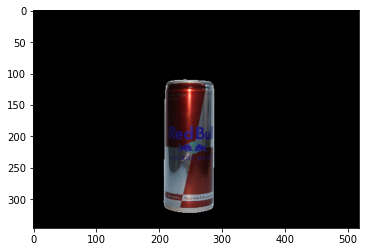

In [5]:
# Preprocessing an example image
filename = '../data/raw/ener1_1.jpg'
img = preprocess(filename)

plt.imshow(img);

In [6]:
# Preprocess all images and Save them to a new directory `processed`

filenames = glob.glob(os.path.join(data_dir, '*.JPG')) # list all image file names in the data folder
proc_data_dir = '../data/processed'

for fname in filenames:
    img_name = os.path.basename(fname)
    img = preprocess(fname)
    cv2.imwrite(os.path.join(proc_data_dir, os.path.splitext(img_name)[0] + '_processed.png'), img)

In [7]:
# Function for visualizing a Car Plug (with all its 8 images)

def show_plug(plug_name, data_dir, preprocess=None):
    # Read Images
    plug_fnames = glob.glob(os.path.join(data_dir, f'{plug_name}*.JPG'))
    if preprocess:
        plug_images = [preprocess(plug_fname) for plug_fname in plug_fnames]
    else:
        plug_images = [cv2.cvtColor(cv2.imread(plug_fname), cv2.COLOR_BGR2RGB) for plug_fname in plug_fnames]
    # Visualize Images
    plt.figure(figsize=(18,8))
    for i in range(len(plug_images)):
        plt.subplot(2, 4, i+1)
        plt.imshow(plug_images[i])
        plt.title(os.path.basename(plug_fnames[i]))
        plt.xticks([])
        plt.yticks([])
        
    plt.suptitle(f'Item: {plug_name}', size=20)
    
    


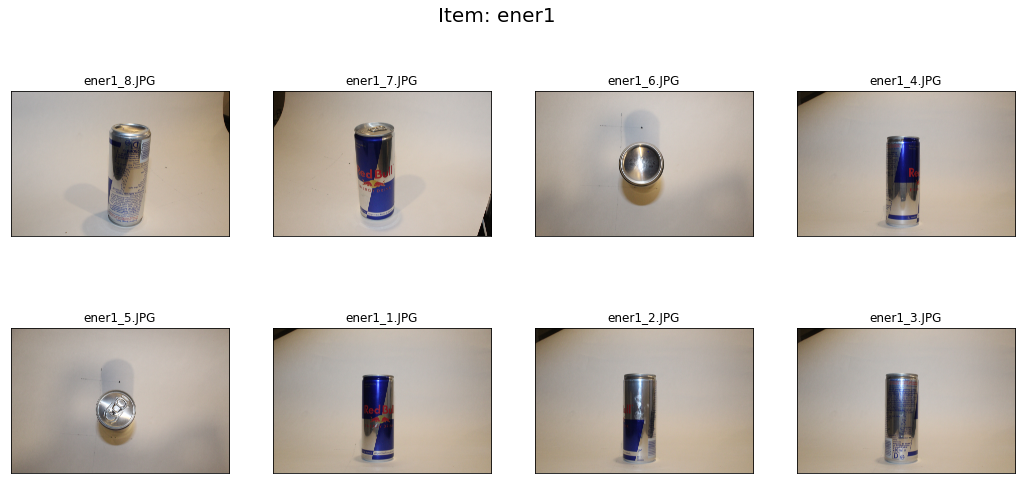

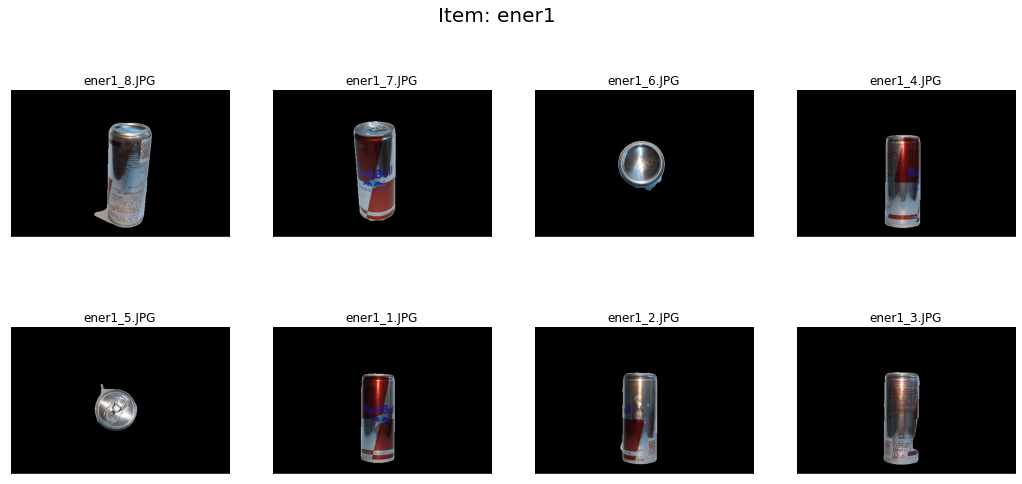

In [8]:
# Example Visualization

plug_name = 'ener1'
show_plug(plug_name, data_dir)
show_plug(plug_name, data_dir, preprocess=preprocess)

## III. Multi-View Convolutional Neural Network (MVCNN)

## 1. Create A Custom PyTorch Dataset

In [9]:
class CarPlugDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.nb_views = 8
        self.plug_label_map = self._get_plug_label_map(root + '/train.csv')
        self.plug_names = self._get_plug_names(root)
        self.label_encoder = class_id_map
        
    def _get_plug_names(self, root):
        plug_names = [fname.split('_')[0] for fname in os.listdir(root) if fname.endswith('.png')]
        plug_names = list(set(plug_names))
        return plug_names
    
    def _get_plug_label_map(self, filename):
        reader = csv.DictReader(open(filename))
        plug_label_map = {}
        for row in reader:
            plug_label_map[row['part_no']] = row['label']
        return plug_label_map
        
    def __len__(self):
        return len(self.plug_names)
    
    def _transform(self, image):
        transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        return transform(image)
    
    def __getitem__(self, index):
        plug_name = self.plug_names[index]
        # Get Images of the Plug
        plug_fnames = glob.glob(self.root + f'/{plug_name}_*.png')
        plug = torch.stack([self._transform(Image.open(fname).convert('RGB')) for fname in plug_fnames])
        label = self.label_encoder[self.plug_label_map[plug_name]]
        return plug, label
    
     

In [10]:
# CREATE DATASET
root = '../data/processed'
dataset = CarPlugDataset(root)

In [13]:
# CREATE STRATIFIED TRAIN-VALIDATION SPLIT INDICES
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
y = [dataset.plug_label_map[plug] for plug in dataset.plug_names]

train_indices, val_indices = next(sss.split(np.zeros(len(y)), y))

In [14]:
# CREATE TRAIN AND VALIDATION DATA LOADERS
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=31, sampler=train_sampler, num_workers=0)
val_loader = DataLoader(dataset, batch_size=31, sampler=val_sampler, num_workers=0)
data_loaders = {'train': train_loader, 'val': val_loader}

## 2. Create the Multi-View CNN (MVCNN) Architecture 

In [15]:
# MULTI-VIEW CONVOLUTIONAL NEURAL NETWORK (MVCNN) ARCHITECTURE

class MVCNN(nn.Module):
    def __init__(self, num_classes=1000, pretrained=True):
        super(MVCNN, self).__init__()
        resnet = models.resnet34(pretrained = pretrained)
        fc_in_features = resnet.fc.in_features
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(fc_in_features, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes)
        )

    def forward(self, inputs): # inputs.shape = samples x views x height x width x channels
        inputs = inputs.transpose(0, 1)
        view_features = [] 
        for view_batch in inputs:
            view_batch = self.features(view_batch)
            view_batch = view_batch.view(view_batch.shape[0], view_batch.shape[1:].numel())
            view_features.append(view_batch)   
            
        pooled_views, _ = torch.max(torch.stack(view_features), 0)
        outputs = self.classifier(pooled_views)
        return outputs

In [16]:
# BUILD AND VISUALIZE THE MODEL
model = MVCNN(num_classes=9, pretrained=True)
print(model)

MVCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## 3. Train the MVCNN Model

In [17]:
# DEFINE THE DEVICE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
# DEFINE A FUNCTION TO TRAIN THE MODEL

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # Get model predictions
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.append(preds)
                all_labels.append(labels)

            epoch_loss = running_loss / len(dataloaders[phase].sampler.indices)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler.indices)
            all_labels = torch.cat(all_labels, 0)
            all_preds = torch.cat(all_preds, 0)
            epoch_weighted_acc = accuracy_score(all_labels.cpu().numpy(), all_preds.cpu().numpy())
            

            print('{} Loss: {:.4f} - Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_weighted_acc > best_acc:
                best_acc = epoch_weighted_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_weighted_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### 3.1 Training the Classifier Block of the Network

In [19]:
# FREEZE THE WEIGHTS IN THE FEATURE EXTRACTION BLOCK OF THE NETWORK (I.E. RESNET BASE)
for param in model.features.parameters():
    param.requires_grad = False

In [22]:
# TRAIN THE CLASSIFIER BLOCK OF THE MODEL (I.E TOP DENSE LAYERS)
model.to(device)
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

model, val_acc_history = train_model(model=model, dataloaders=data_loaders, criterion=criterion, optimizer=optimizer, num_epochs=EPOCHS)

Epoch 1/20
----------
train Loss: 2.2225 - Acc: 0.2059
val Loss: 2.0798 - Acc: 0.4000

Epoch 2/20
----------
train Loss: 2.1659 - Acc: 0.1471
val Loss: 2.0545 - Acc: 0.0667

Epoch 3/20
----------
train Loss: 2.0622 - Acc: 0.0882
val Loss: 1.8883 - Acc: 0.2667

Epoch 4/20
----------
train Loss: 1.9970 - Acc: 0.1765
val Loss: 1.7196 - Acc: 0.4667

Epoch 5/20
----------
train Loss: 1.7837 - Acc: 0.2647
val Loss: 1.5831 - Acc: 0.4667

Epoch 6/20
----------
train Loss: 1.5869 - Acc: 0.5000
val Loss: 1.6289 - Acc: 0.4667

Epoch 7/20
----------
train Loss: 1.6084 - Acc: 0.5000
val Loss: 1.6374 - Acc: 0.3333

Epoch 8/20
----------
train Loss: 1.5349 - Acc: 0.4706
val Loss: 1.3898 - Acc: 0.5333

Epoch 9/20
----------
train Loss: 1.3707 - Acc: 0.5588
val Loss: 1.2528 - Acc: 0.6667

Epoch 10/20
----------
train Loss: 1.2835 - Acc: 0.5882
val Loss: 1.2092 - Acc: 0.5333

Epoch 11/20
----------
train Loss: 1.3825 - Acc: 0.4706
val Loss: 1.2927 - Acc: 0.4667

Epoch 12/20
----------
train Loss: 1.5708

In [23]:
# SAVE CURRENT WEIGHTS OF THE MODEL (STAGE 1: FEATURE EXTRACTION)
torch.save(model.state_dict(), '../models/mvcnn_stage_1.pkl')

### 3.2 Fine-Tuning the Entire Network (Feature Extractor + Classifier Blocks)

In [24]:
# UNFREEZE ALL THE WEIGHTS OF THE NETWORK
for param in model.parameters():
    param.requires_grad = True

In [26]:
# FINE-TUNE THE ENTIRE MODEL (I.E FEATURE EXTRACTOR + CLASSIFIER BLOCKS) USING A VERY SMALL LEARNING RATE
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005) # We use a smaller learning rate

model, val_acc_history = train_model(model=model, dataloaders=data_loaders, criterion=criterion, optimizer=optimizer, num_epochs=EPOCHS)

Epoch 1/10
----------
train Loss: 1.0943 - Acc: 0.6471
val Loss: 0.7434 - Acc: 0.9333

Epoch 2/10
----------
train Loss: 0.6824 - Acc: 0.8529
val Loss: 0.6535 - Acc: 0.9333

Epoch 3/10
----------
train Loss: 0.6106 - Acc: 0.9412
val Loss: 0.5598 - Acc: 1.0000

Epoch 4/10
----------
train Loss: 0.7383 - Acc: 0.8235
val Loss: 0.5674 - Acc: 1.0000

Epoch 5/10
----------
train Loss: 0.5376 - Acc: 0.9412
val Loss: 0.5582 - Acc: 0.9333

Epoch 6/10
----------
train Loss: 0.6735 - Acc: 0.8235
val Loss: 0.4577 - Acc: 0.9333

Epoch 7/10
----------
train Loss: 0.5562 - Acc: 0.8824
val Loss: 0.4210 - Acc: 1.0000

Epoch 8/10
----------
train Loss: 0.5288 - Acc: 0.8824
val Loss: 0.5126 - Acc: 1.0000

Epoch 9/10
----------
train Loss: 0.4003 - Acc: 0.9706
val Loss: 0.4107 - Acc: 1.0000

Epoch 10/10
----------
train Loss: 0.4174 - Acc: 0.9412
val Loss: 0.4170 - Acc: 1.0000

Training complete in 605m 2s
Best val Acc: 1.000000


In [27]:
# SAVE CURRENT WEIGHTS OF THE MODEL (STAGE 2: FINE-TUNING)
torch.save(model.state_dict(), '../models/mvcnn_stage_2.pkl')

In [28]:
# FUNCTION TO GET PREDICTIONS FOR NEW CAR PLUGS
def mvcnn_pred(plug_name, data_dir, model, device):
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    plug_fnames = glob.glob(data_dir + f'/{plug_name}_*.png')
    plug = torch.stack([transform(Image.open(fname).convert('RGB')) for fname in plug_fnames]).unsqueeze(0)
    plug = plug.to(device)
    pred = torch.nn.functional.softmax(model(plug)).argmax().item()
    return pred, {v:k for k,v in class_id_map.items()}[pred]



In [ ]:
# GET NEW PREDICTIONS FROM RAW IMAGES USING A CAR PLUG NAME
mvcnn_pred(plug_name, '../data/processed', model, device)
for plug_name in plug_names:
    print('initial: ', plug_name, ' guess: ', mvcnn_pred(plug_name, '../data/processed', model, device))